In [28]:
# ! pip install statsmodels

In [30]:
# !pip install --user pmdarima

     -------------------------------------- 601.9/601.9 kB 6.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import math

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus'] = False

path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

plt.style.use('seaborn-whitegrid')
%matplotlib inline

import itertools

import warnings
warnings.filterwarnings(action='ignore')

# 데이터 처리

## 재무제표 날짜 2month shift

In [2]:
df = pd.read_csv('c:/Users/bitcamp/Desktop/final_data/머신러닝_재무데이터/종목별_511_자본금_이익잉여금_x_20drop/000040.csv', index_col=0)

In [3]:
df

,date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,...,유동부채,비유동부채,부채총계,이익잉여금,자본총계,매출액,영업이익,법인세차감전 순이익,당기순이익,자본금
0,2016-01-04,1295,1325,1255,1305,6053163,7839874495,2.76,40,228776632020,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
1,2016-01-05,1285,1350,1280,1310,9674168,12787405175,0.38,40,229653170840,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
2,2016-01-06,1320,1325,1205,1260,5368790,6871631090,-3.82,40,220887782640,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
3,2016-01-07,1265,1280,1210,1230,2538804,3132011390,-2.38,40,215628549720,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
4,2016-01-08,1200,1255,1155,1235,2977602,3568370425,0.41,40,216505088540,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2022-03-25,889,907,883,890,767469,682703893,-1.11,40,85562257520,...,9.518024e+10,2.263642e+10,1.178167e+11,-3.090048e+10,4.738370e+10,2.915054e+10,-1.352668e+09,-3.055328e+09,-3.055328e+09,4.806882e+10
1530,2022-03-28,890,904,879,902,710517,637034052,1.35,40,86715905936,...,9.518024e+10,2.263642e+10,1.178167e+11,-3.090048e+10,4.738370e+10,2.915054e+10,-1.352668e+09,-3.055328e+09,-3.055328e+09,4.806882e+10
1531,2022-03-29,908,908,863,887,472182,419609723,-1.66,40,85273845416,...,9.518024e+10,2.263642e+10,1.178167e+11,-3.090048e+10,4.738370e+10,2.915054e+10,-1.352668e+09,-3.055328e+09,-3.055328e+09,4.806882e+10
1532,2022-03-30,887,892,867,881,230386,203707513,-0.68,40,84697021208,...,9.518024e+10,2.263642e+10,1.178167e+11,-3.090048e+10,4.738370e+10,2.915054e+10,-1.352668e+09,-3.055328e+09,-3.055328e+09,4.806882e+10


In [4]:
df[['quarter', '유동자산', '비유동자산', '자산총계', '유동부채', '비유동부채',
       '부채총계', '이익잉여금', '자본총계', '매출액', '영업이익', '법인세차감전 순이익', '당기순이익', '자본금']] = df[['quarter', '유동자산', '비유동자산', '자산총계', '유동부채', '비유동부채',
       '부채총계', '이익잉여금', '자본총계', '매출액', '영업이익', '법인세차감전 순이익', '당기순이익', '자본금']].shift(80)

In [5]:
df

,date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,...,유동부채,비유동부채,부채총계,이익잉여금,자본총계,매출액,영업이익,법인세차감전 순이익,당기순이익,자본금
0,2016-01-04,1295,1325,1255,1305,6053163,7839874495,2.76,40,228776632020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-05,1285,1350,1280,1310,9674168,12787405175,0.38,40,229653170840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-06,1320,1325,1205,1260,5368790,6871631090,-3.82,40,220887782640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-07,1265,1280,1210,1230,2538804,3132011390,-2.38,40,215628549720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-08,1200,1255,1155,1235,2977602,3568370425,0.41,40,216505088540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2022-03-25,889,907,883,890,767469,682703893,-1.11,40,85562257520,...,9.552199e+10,2.268918e+10,1.182112e+11,-2.866988e+10,5.022564e+10,9.900577e+10,-2.468118e+09,-1.018985e+10,-1.017489e+10,4.806868e+10
1530,2022-03-28,890,904,879,902,710517,637034052,1.35,40,86715905936,...,9.552199e+10,2.268918e+10,1.182112e+11,-2.866988e+10,5.022564e+10,9.900577e+10,-2.468118e+09,-1.018985e+10,-1.017489e+10,4.806868e+10
1531,2022-03-29,908,908,863,887,472182,419609723,-1.66,40,85273845416,...,9.552199e+10,2.268918e+10,1.182112e+11,-2.866988e+10,5.022564e+10,9.900577e+10,-2.468118e+09,-1.018985e+10,-1.017489e+10,4.806868e+10
1532,2022-03-30,887,892,867,881,230386,203707513,-0.68,40,84697021208,...,9.552199e+10,2.268918e+10,1.182112e+11,-2.866988e+10,5.022564e+10,9.900577e+10,-2.468118e+09,-1.018985e+10,-1.017489e+10,4.806868e+10


## test set 빼기

In [6]:
train_df = df[df['date'] < '2021-10']

In [7]:
train_df

,date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,...,유동부채,비유동부채,부채총계,이익잉여금,자본총계,매출액,영업이익,법인세차감전 순이익,당기순이익,자본금
0,2016-01-04,1295,1325,1255,1305,6053163,7839874495,2.76,40,228776632020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-05,1285,1350,1280,1310,9674168,12787405175,0.38,40,229653170840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-06,1320,1325,1205,1260,5368790,6871631090,-3.82,40,220887782640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-07,1265,1280,1210,1230,2538804,3132011390,-2.38,40,215628549720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-08,1200,1255,1155,1235,2977602,3568370425,0.41,40,216505088540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,2021-09-24,1055,1055,1035,1035,304830,317371200,-1.90,40,99502175880,...,1.005802e+11,2.285437e+10,1.234345e+11,-4.883689e+10,5.243179e+10,1.529203e+10,2.234482e+09,701699521.0,701699521.0,4.806868e+10
1408,2021-09-27,1055,1055,1025,1050,261239,272400835,1.45,40,100944236400,...,1.005802e+11,2.285437e+10,1.234345e+11,-4.883689e+10,5.243179e+10,1.529203e+10,2.234482e+09,701699521.0,701699521.0,4.806868e+10
1409,2021-09-28,1055,1065,1025,1025,268247,278570750,-2.38,40,98540802200,...,1.005802e+11,2.285437e+10,1.234345e+11,-4.883689e+10,5.243179e+10,1.529203e+10,2.234482e+09,701699521.0,701699521.0,4.806868e+10
1410,2021-09-29,1025,1030,1000,1015,346385,350074835,-0.98,40,97579428520,...,1.005802e+11,2.285437e+10,1.234345e+11,-4.883689e+10,5.243179e+10,1.529203e+10,2.234482e+09,701699521.0,701699521.0,4.806868e+10


In [8]:
test_df = df[df['date'] > '2021-09']
test_df

,date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,...,유동부채,비유동부채,부채총계,이익잉여금,자본총계,매출액,영업이익,법인세차감전 순이익,당기순이익,자본금
1393,2021-09-01,1125,1135,1115,1130,204474,230928240,0.44,40,108635225840,...,1.005802e+11,2.285437e+10,1.234345e+11,-4.883689e+10,5.243179e+10,1.529203e+10,2.234482e+09,7.016995e+08,7.016995e+08,4.806868e+10
1394,2021-09-02,1145,1145,1120,1130,219167,247221410,0.00,40,108635225840,...,1.005802e+11,2.285437e+10,1.234345e+11,-4.883689e+10,5.243179e+10,1.529203e+10,2.234482e+09,7.016995e+08,7.016995e+08,4.806868e+10
1395,2021-09-03,1130,1140,1115,1125,308596,347645670,-0.44,40,108154539000,...,1.005802e+11,2.285437e+10,1.234345e+11,-4.883689e+10,5.243179e+10,1.529203e+10,2.234482e+09,7.016995e+08,7.016995e+08,4.806868e+10
1396,2021-09-06,1130,1130,1105,1120,351201,391703345,-0.44,40,107673852160,...,1.005802e+11,2.285437e+10,1.234345e+11,-4.883689e+10,5.243179e+10,1.529203e+10,2.234482e+09,7.016995e+08,7.016995e+08,4.806868e+10
1397,2021-09-07,1125,1135,1105,1110,226623,252024010,-0.89,40,106712478480,...,1.005802e+11,2.285437e+10,1.234345e+11,-4.883689e+10,5.243179e+10,1.529203e+10,2.234482e+09,7.016995e+08,7.016995e+08,4.806868e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2022-03-25,889,907,883,890,767469,682703893,-1.11,40,85562257520,...,9.552199e+10,2.268918e+10,1.182112e+11,-2.866988e+10,5.022564e+10,9.900577e+10,-2.468118e+09,-1.018985e+10,-1.017489e+10,4.806868e+10
1530,2022-03-28,890,904,879,902,710517,637034052,1.35,40,86715905936,...,9.552199e+10,2.268918e+10,1.182112e+11,-2.866988e+10,5.022564e+10,9.900577e+10,-2.468118e+09,-1.018985e+10,-1.017489e+10,4.806868e+10
1531,2022-03-29,908,908,863,887,472182,419609723,-1.66,40,85273845416,...,9.552199e+10,2.268918e+10,1.182112e+11,-2.866988e+10,5.022564e+10,9.900577e+10,-2.468118e+09,-1.018985e+10,-1.017489e+10,4.806868e+10
1532,2022-03-30,887,892,867,881,230386,203707513,-0.68,40,84697021208,...,9.552199e+10,2.268918e+10,1.182112e+11,-2.866988e+10,5.022564e+10,9.900577e+10,-2.468118e+09,-1.018985e+10,-1.017489e+10,4.806868e+10


In [9]:
# nan값 제거
train_df.dropna(inplace=True)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_7184/2539631187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(inplace=True)


In [10]:
train_df.head(30)

,date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,...,유동부채,비유동부채,부채총계,이익잉여금,자본총계,매출액,영업이익,법인세차감전 순이익,당기순이익,자본금
80,2016-05-02,1200,1230,1185,1200,1628765,1970038645,0.00,40,210369316800,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
81,2016-05-03,1195,1210,1190,1200,1124667,1346750290,0.00,40,210369316800,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
82,2016-05-04,1210,1210,1180,1180,899009,1067538005,-1.67,40,206863161520,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
83,2016-05-09,1180,1185,1145,1165,791397,916304725,-1.27,40,204233545060,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
84,2016-05-10,1165,1185,1155,1180,505195,591368255,1.29,40,206863161520,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
85,2016-05-11,1185,1190,1165,1165,370527,434640415,-1.27,40,204233545060,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
86,2016-05-12,1155,1185,1155,1170,645585,753747170,0.43,40,205110083880,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
87,2016-05-13,1180,1210,1170,1205,1239852,1481806475,2.99,40,211245855620,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
88,2016-05-16,1195,1220,1170,1185,1421727,1694529310,-1.66,40,207739700340,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10
89,2016-05-17,1180,1185,1150,1155,1126132,1310947925,-2.53,40,202480467420,...,6.620836e+10,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10


## 기간별 updown

In [11]:
plus_li = []
n = 30

for sh in range(len(train_df)):
    try:
        plus = (train_df.iloc[n,4] - train_df.iloc[sh,4]) / train_df.iloc[sh,4] * 100
        plus_li.append(math.trunc(plus))
        n+=1
    except:
        plus_li.append(np.nan)

In [12]:
len(plus_li)

1332

In [13]:
plus_li

[-5,
 -5,
 -4,
 -1,
 -1,
 -3,
 -8,
 -10,
 -4,
 -1,
 0,
 1,
 0,
 4,
 7,
 12,
 11,
 10,
 10,
 6,
 4,
 4,
 4,
 2,
 3,
 8,
 14,
 7,
 3,
 0,
 3,
 2,
 2,
 1,
 0,
 3,
 7,
 6,
 -4,
 -2,
 -3,
 -4,
 -3,
 -6,
 -7,
 -5,
 -4,
 -5,
 -2,
 -3,
 -4,
 -3,
 -3,
 -5,
 -5,
 -8,
 -14,
 -7,
 -6,
 -7,
 -9,
 -7,
 -6,
 -6,
 -6,
 -8,
 -6,
 -6,
 0,
 -4,
 -3,
 -2,
 -3,
 -2,
 -4,
 -7,
 -5,
 -5,
 -6,
 -6,
 -5,
 -6,
 -7,
 -4,
 -7,
 -8,
 -8,
 -9,
 -10,
 -11,
 -8,
 -11,
 -13,
 -13,
 -16,
 -15,
 -16,
 -14,
 -12,
 -17,
 -13,
 -14,
 -13,
 -13,
 -12,
 -11,
 -17,
 -16,
 -18,
 -21,
 -25,
 -14,
 -13,
 -15,
 -16,
 -21,
 -20,
 -23,
 -20,
 -20,
 -20,
 -19,
 -14,
 -12,
 -7,
 -5,
 -4,
 -5,
 -7,
 0,
 -5,
 -6,
 -6,
 -6,
 -5,
 -6,
 -1,
 1,
 5,
 10,
 15,
 1,
 2,
 0,
 -2,
 11,
 7,
 11,
 10,
 13,
 8,
 4,
 -1,
 -3,
 -3,
 -8,
 -7,
 -10,
 -10,
 -9,
 -2,
 -5,
 -8,
 -8,
 -9,
 -9,
 -11,
 -13,
 -13,
 -16,
 -15,
 -15,
 -12,
 -10,
 -4,
 -10,
 -9,
 -9,
 -10,
 -7,
 -4,
 -2,
 1,
 0,
 -1,
 1,
 0,
 2,
 2,
 0,
 -8,
 -4,
 0,
 0,
 0,
 -1,
 -1,
 0,
 0,
 

In [14]:
plus_li[-50:]

[-13,
 -13,
 -11,
 -13,
 -12,
 -10,
 -10,
 -11,
 -12,
 -11,
 -11,
 -9,
 -11,
 -13,
 -13,
 -13,
 -12,
 -13,
 -12,
 -10,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [15]:
train_df['수익률'] = plus_li
train_df.head(2)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_7184/91462970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['수익률'] = plus_li


,date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,...,비유동부채,부채총계,이익잉여금,자본총계,매출액,영업이익,법인세차감전 순이익,당기순이익,자본금,수익률
80,2016-05-02,1200,1230,1185,1200,1628765,1970038645,0.0,40,210369316800,...,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10,-5.0
81,2016-05-03,1195,1210,1190,1200,1124667,1346750290,0.0,40,210369316800,...,1.466770e+10,8.087606e+10,-3.186228e+10,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10,-5.0


In [16]:
# nan값 제거
train_df.dropna(inplace=True)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_7184/2539631187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(inplace=True)


## target값

In [17]:
# 5%
per_li_5 = []
count = 0
for t in range(len(train_df)):
    if train_df.iloc[t, -1] > 5:
        per_li_5.append(1)
        print(train_df.iloc[t,0])
        count += 1
    else:
        per_li_5.append(0)

2016-05-24
2016-05-25
2016-05-26
2016-05-27
2016-05-30
2016-05-31
2016-06-09
2016-06-10
2016-06-13
2016-06-24
2016-06-27
2016-11-23
2016-11-24
2016-12-01
2016-12-02
2016-12-05
2016-12-06
2016-12-07
2016-12-08
2017-03-29
2017-03-30
2017-03-31
2017-04-03
2017-04-04
2017-04-05
2017-04-06
2017-04-07
2017-04-10
2017-04-11
2017-04-12
2017-04-13
2017-04-14
2017-04-17
2017-04-18
2017-04-19
2017-04-20
2017-04-21
2017-04-24
2017-04-25
2017-04-26
2017-04-27
2017-04-28
2017-05-02
2017-05-04
2017-05-08
2017-05-10
2017-05-11
2017-05-12
2017-05-15
2017-05-24
2017-05-25
2017-05-26
2017-05-29
2017-11-28
2017-11-29
2017-11-30
2017-12-01
2017-12-04
2017-12-05
2017-12-06
2017-12-07
2017-12-08
2017-12-11
2017-12-12
2017-12-13
2017-12-14
2017-12-15
2017-12-18
2017-12-19
2017-12-20
2017-12-21
2017-12-22
2017-12-26
2017-12-27
2017-12-28
2018-01-02
2018-01-03
2018-01-04
2018-01-05
2018-01-08
2018-01-09
2018-01-10
2018-01-11
2018-02-19
2018-02-20
2018-02-21
2018-02-22
2018-02-23
2018-02-26
2018-02-27
2018-02-28

In [18]:
count

357

In [19]:
# 10%
per_li_10 = []
count = 0
for t in range(len(train_df)):
    if train_df.iloc[t, -1] > 10:
        per_li_10.append(1)
        print(train_df.iloc[t,0])
        count+=1
    else:
        per_li_10.append(0)

2016-05-25
2016-05-26
2016-06-10
2016-11-24
2016-12-01
2016-12-05
2016-12-07
2017-03-30
2017-04-04
2017-04-05
2017-04-06
2017-04-07
2017-04-10
2017-04-11
2017-04-12
2017-04-13
2017-04-14
2017-04-17
2017-04-18
2017-04-19
2017-04-20
2017-04-21
2017-04-24
2017-04-25
2017-04-26
2017-04-27
2017-04-28
2017-05-02
2017-05-04
2017-05-08
2017-05-10
2017-05-11
2017-05-12
2017-05-25
2017-05-26
2017-05-29
2017-11-28
2017-11-29
2017-11-30
2017-12-01
2017-12-04
2017-12-05
2017-12-06
2017-12-07
2017-12-08
2017-12-11
2017-12-12
2017-12-13
2017-12-14
2017-12-15
2017-12-18
2017-12-19
2017-12-20
2017-12-21
2017-12-22
2017-12-26
2017-12-27
2017-12-28
2018-01-02
2018-01-03
2018-01-04
2018-01-05
2018-01-08
2018-01-09
2018-01-10
2018-01-11
2018-03-06
2018-03-07
2018-03-09
2018-03-12
2018-03-13
2018-03-14
2018-03-19
2018-03-21
2018-03-22
2018-03-23
2018-03-26
2018-03-27
2018-03-28
2018-03-29
2018-03-30
2018-04-02
2018-04-03
2018-04-04
2018-04-05
2018-04-06
2018-04-09
2018-04-10
2018-04-11
2018-04-12
2018-04-13

In [20]:
count

266

In [21]:
# 15%
per_li_15 = []
count = 0
for t in range(len(train_df)):
    if train_df.iloc[t, -1] > 15:
        per_li_15.append(1)
#         print(train_df.iloc[t,0])
        count+=1
    else:
        per_li_15.append(0)

In [22]:
count

216

In [23]:
train_df['5per'] = per_li_5
train_df['10per'] = per_li_10
train_df['15per'] = per_li_15

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_7184/3715455053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['5per'] = per_li_5
C:\Users\bitcamp\AppData\Local\Temp/ipykernel_7184/3715455053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['10per'] = per_li_10
C:\Users\bitcamp\AppData\Local\Temp/ipykernel_7184/3715455053.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [24]:
train_df

,date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,...,자본총계,매출액,영업이익,법인세차감전 순이익,당기순이익,자본금,수익률,5per,10per,15per
80,2016-05-02,1200,1230,1185,1200,1628765,1970038645,0.00,40,210369316800,...,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10,-5.0,0,0,0
81,2016-05-03,1195,1210,1190,1200,1124667,1346750290,0.00,40,210369316800,...,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10,-5.0,0,0,0
82,2016-05-04,1210,1210,1180,1180,899009,1067538005,-1.67,40,206863161520,...,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10,-4.0,0,0,0
83,2016-05-09,1180,1185,1145,1165,791397,916304725,-1.27,40,204233545060,...,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10,-1.0,0,0,0
84,2016-05-10,1165,1185,1155,1180,505195,591368255,1.29,40,206863161520,...,6.502035e+10,1.979041e+10,-2.729799e+09,-3.476061e+09,-3.476061e+09,8.765388e+10,-1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,2021-08-09,1230,1230,1185,1200,701770,840512140,-2.04,40,115364841600,...,5.243179e+10,1.529203e+10,2.234482e+09,7.016995e+08,7.016995e+08,4.806868e+10,-13.0,0,0,0
1378,2021-08-10,1200,1205,1185,1195,543534,647809910,-0.42,40,114884154760,...,5.243179e+10,1.529203e+10,2.234482e+09,7.016995e+08,7.016995e+08,4.806868e+10,-12.0,0,0,0
1379,2021-08-11,1195,1200,1160,1180,758078,890687130,-1.26,40,113442094240,...,5.243179e+10,1.529203e+10,2.234482e+09,7.016995e+08,7.016995e+08,4.806868e+10,-13.0,0,0,0
1380,2021-08-12,1180,1185,1160,1165,426966,498898055,-1.27,40,112000033720,...,5.243179e+10,1.529203e+10,2.234482e+09,7.016995e+08,7.016995e+08,4.806868e+10,-12.0,0,0,0


In [25]:
train_df.isna().sum()

date          0
시가            0
고가            0
저가            0
종가            0
거래량           0
거래대금          0
등락률           0
종목명           0
시가총액          0
상장주식수         0
수정종가          0
quarter       0
유동자산          0
비유동자산         0
자산총계          0
유동부채          0
비유동부채         0
부채총계          0
이익잉여금         0
자본총계          0
매출액           0
영업이익          0
법인세차감전 순이익    0
당기순이익         0
자본금           0
수익률           0
5per          0
10per         0
15per         0
dtype: int64

# machine

## ARIMA

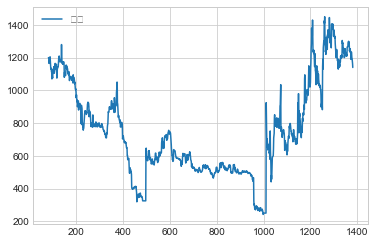

In [36]:
stock_data = train_df[['종가']]
fig = stock_data.plot()

In [37]:
stock_data_train, stock_data_test = train_test_split(stock_data, test_size=0.05, shuffle=False)

In [39]:
fig, ax = plt.subplot(1,2, figsize = (10,5))
fig.subplot('Raw Data')
sm.graphics.tsa.plot_acf(stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(stock_data_train.values.squeeze(), lags=40, ax=ax[1]);

TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

<Figure size 432x288 with 0 Axes>